# Tests with Popoola's MLP for FL + IDS

## Authors given information

| Hyperparameter                    | Value                 |
| --------------------------------- | ---------------------:|
| Input neurons                     | 39                    |
| Hidden layers                     | 2                     |
| Neurons in each hidden layer      | 128                   |
| Hidden layer activation function  | ReLU                  |
| Output neuron                     | 1                     |
| Output layer activation function  | Sigmoid               |
| Optimisation algorithm            | Adam                  |
| Learning rate                     | 0.0001                |
| Batch size                        | 512                   |
| Epochs                            | 10                    |
| Loss function                     | Binary cross-entropy  |


In [1]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


keras = tf.keras


In [3]:
# Enable determinsim
SEED = 1138

tf.keras.utils.set_random_seed(SEED)  # sets seeds for base-python, numpy and tf
tf.config.experimental.enable_op_determinism()


In [4]:

from typing import Tuple
from trustfids.dataset.common import Dataset
from trustfids.dataset.nfv2 import load_data


cicids: Tuple[Dataset, Dataset] = load_data("../data/sampled/cicids.csv.gz", test_ratio=0.2) # type: ignore

cicids_train, cicids_test = cicids


2024-02-08 10:59:04,080	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [5]:
def build_model() -> keras.Model:

    model = keras.Sequential([
        keras.layers.Dense(128, activation='relu', input_shape=[len(cicids_train.X.columns)]),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.0001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model


## CIC-IDS2017

In [6]:
cicids_model = build_model()

cicids_history = cicids_model.fit(
    cicids_train.to_sequence(batch_size=512, target=1),#, shuffle=True, seed=SEED),
    epochs=10,
    #batch_size=512,
)

loss, acc = cicids_model.evaluate(cicids_test.X, cicids_test.y)


Epoch 1/10
1563/1563 [==============================] - 5s 2ms/step - loss: 0.1722 - accuracy: 0.9539
Epoch 2/10
1563/1563 [==============================] - 4s 2ms/step - loss: 0.0785 - accuracy: 0.9784
Epoch 3/10
1563/1563 [==============================] - 4s 2ms/step - loss: 0.0623 - accuracy: 0.9860
Epoch 4/10
1563/1563 [==============================] - 4s 2ms/step - loss: 0.0537 - accuracy: 0.9875
Epoch 5/10
1563/1563 [==============================] - 3s 2ms/step - loss: 0.0487 - accuracy: 0.9888
Epoch 6/10
1563/1563 [==============================] - 4s 2ms/step - loss: 0.0457 - accuracy: 0.9895
Epoch 7/10
1563/1563 [==============================] - 4s 2ms/step - loss: 0.0435 - accuracy: 0.9899
Epoch 8/10
1563/1563 [==============================] - 4s 2ms/step - loss: 0.0417 - accuracy: 0.9904
Epoch 9/10
1563/1563 [==============================] - 4s 3ms/step - loss: 0.0400 - accuracy: 0.9912
Epoch 10/10
6250/6250 [==============================] - 5s 742us/step - loss: 0.0

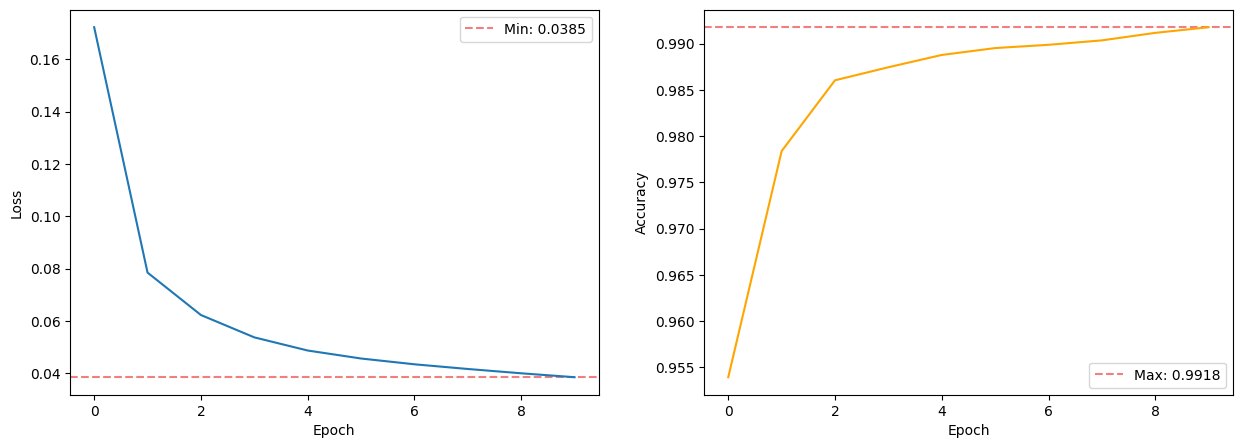

Accuracy: 0.9913


In [7]:


# plot training history, loss and accuracy side by side
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
_min = np.min(cicids_history.history['loss'])
ax1.axhline(y=_min, label=f"Min: {_min:.4f}", linestyle='--', color='lightcoral')
ax1.plot(cicids_history.history['loss'])
ax1.set_ylabel('Loss')
ax1.set_xlabel('Epoch')
ax1.legend()
_max = np.max(cicids_history.history['accuracy'])
ax2.axhline(y=_max, label=f"Max: {_max:.4f}", linestyle='--', color='lightcoral')
ax2.plot(cicids_history.history['accuracy'], color='orange')
ax2.set_ylabel('Accuracy')
ax2.set_xlabel('Epoch')
ax2.legend()
plt.show()

print(f"Accuracy: {acc:.4f}")


In [8]:
# plot evaluation metrics
inferences = cicids_model.predict(cicids_test.X)
print(inferences.shape)
print(f"First 10 predictions:\n{inferences[:10]}")

6250/6250 [==============================] - 4s 612us/step
(199997, 1)
First 10 predictions:
[[1.8332859e-03]
 [8.2015330e-03]
 [3.6512871e-04]
 [6.8067113e-04]
 [9.2866355e-01]
 [1.7353632e-03]
 [9.9415481e-01]
 [1.1534233e-03]
 [7.4427347e-03]
 [7.7034584e-03]]


True Negatives: 175848
False Positives: 277
False Negatives: 1463
True Positives: 22409


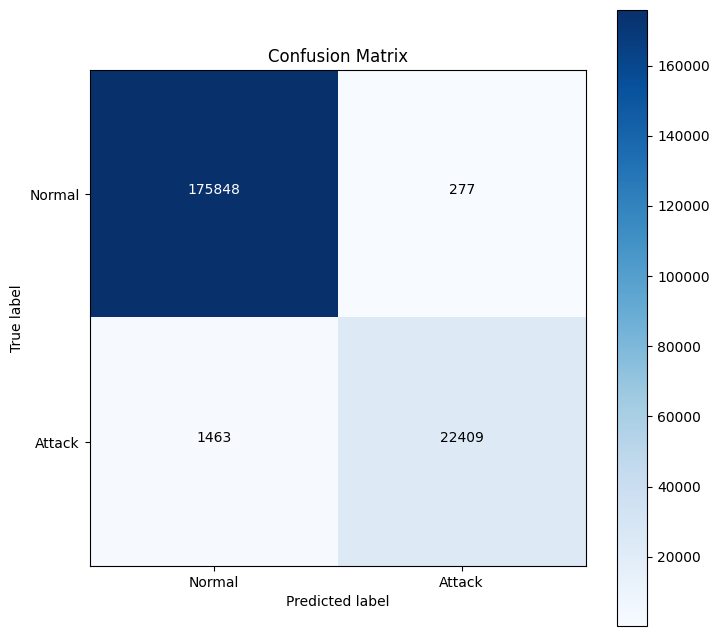

CIC-IDS Accuracy: 0.9913
CIC-IDS Precision: 0.9878
CIC-IDS Recall: 0.9387
CIC-IDS F1: 0.9626
CIC-IDS Miss Rate: 0.0613
CIC-IDS Loss: 0.0382


In [9]:
from sklearn.metrics import confusion_matrix

# convert to binary
#y_pred = np.argmax(np.round(inferences), axis=1)
y_pred = np.round(inferences).astype(int)#.reshape(1,-1)
#y_pred = inferences
#y_true = np.argmax(cicids_test.y.to_numpy(), axis=1)
y_true = cicids_test.y.to_numpy()


# plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = cm.ravel()

print("True Negatives:", tn)
print("False Positives:", fp)
print("False Negatives:", fn)
print("True Positives:", tp)

def plot_cm(cm):
    plt.figure(figsize=(8, 8))
    plt.imshow(cm, cmap=plt.cm.Blues)
    for i in range(2):
        for j in range(2):
            plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > cm.max() / 2. else "black")
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    class_names = ['Normal', 'Attack']
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    plt.title("Confusion Matrix")
    plt.colorbar()
    plt.show()

plot_cm(cm)



cicids_acc = (tn + tp) / (tn + fp + fn + tp)
cicids_prec = tp / (tp + fp)
cicids_rec = tp / (tp + fn)
cicids_f1 = 2 * cicids_prec * cicids_rec / (cicids_prec + cicids_rec)
cicids_miss = fn / (fn + tp)

print(f"CIC-IDS Accuracy: {cicids_acc:.4f}")
print(f"CIC-IDS Precision: {cicids_prec:.4f}")
print(f"CIC-IDS Recall: {cicids_rec:.4f}")
print(f"CIC-IDS F1: {cicids_f1:.4f}")
print(f"CIC-IDS Miss Rate: {cicids_miss:.4f}")
print(f"CIC-IDS Loss: {loss:.4f}")



## Generalizing

In [13]:
from typing import Dict, List, Tuple
from numpy.typing import NDArray

botiot: Tuple[Dataset, Dataset] = load_data("../data/sampled/botiot.csv.gz", test_ratio=0.2, seed=SEED) # type: ignore
nb15: Tuple[Dataset, Dataset] = load_data("../data/sampled/nb15.csv.gz",test_ratio=0.2,  seed=SEED) # type: ignore
toniot: Tuple[Dataset, Dataset] = load_data("../data/sampled/toniot.csv.gz", test_ratio=0.2, seed=SEED) # type: ignore



Weights = List[NDArray]

def eval_on(train, test) -> Tuple[Dict[str, float], Weights]:
    model = build_model()
    model.fit(
        train.X,
        train.y,
        epochs=10,
        batch_size=512,
    )
    inferences = model.predict(test.X)
    y_pred = np.round(inferences).astype(int)
    y_true = test.y.to_numpy()
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    acc = (tn + tp) / (tn + fp + fn + tp)
    prec = tp / (tp + fp)
    rec = tp / (tp + fn)
    f1 = 2 * prec * rec / (prec + rec)
    miss = fn / (fn + tp)
    return {
        "tp": tp,
        "tn": tn,
        "fp": fp,
        "fn": fn,
        "acc": acc,
        "prec": prec,
        "rec": rec,
        "f1": f1,
        "miss": miss
    }, model.get_weights()

In [14]:
cicids_results, cicids_weights = eval_on(*cicids)
nb15_results, nb15_weights = eval_on(*nb15)
toniot_results, toniot_weights = eval_on(*toniot)
botiot_results, botiot_weights = eval_on(*botiot)



Epoch 1/10
1563/1563 [==============================] - 4s 2ms/step - loss: 0.1691 - accuracy: 0.9533
Epoch 2/10
1563/1563 [==============================] - 3s 2ms/step - loss: 0.0805 - accuracy: 0.9773
Epoch 3/10
1563/1563 [==============================] - 3s 2ms/step - loss: 0.0637 - accuracy: 0.9860
Epoch 4/10
1563/1563 [==============================] - 3s 2ms/step - loss: 0.0556 - accuracy: 0.9868
Epoch 5/10
1563/1563 [==============================] - 3s 2ms/step - loss: 0.0507 - accuracy: 0.9891
Epoch 6/10
1563/1563 [==============================] - 3s 2ms/step - loss: 0.0476 - accuracy: 0.9895
Epoch 7/10
1563/1563 [==============================] - 3s 2ms/step - loss: 0.0451 - accuracy: 0.9898
Epoch 8/10
1563/1563 [==============================] - 3s 2ms/step - loss: 0.0431 - accuracy: 0.9901
Epoch 9/10
1563/1563 [==============================] - 3s 2ms/step - loss: 0.0414 - accuracy: 0.9906
Epoch 10/10
6250/6250 [==============================] - 4s 605us/step
Epoch 1/10


In [15]:

df_results: pd.DataFrame = pd.DataFrame(columns=["Dataset", "Accuracy", "Precision", "Recall", "F1", "Miss Rate"])

for dataset in [
    ("CIC-IDS", cicids_results), 
    ("UNSW-NB15", nb15_results),
    ("ToN-IoT", toniot_results),
    ("Bot-IoT", botiot_results),
]:
    df_results = df_results.append({
        "Dataset": dataset[0],
        "Accuracy": dataset[1]["acc"],
        "Precision": dataset[1]["prec"],
        "Recall": dataset[1]["rec"],
        "F1": dataset[1]["f1"],
        "Miss Rate": dataset[1]["miss"]
    }, ignore_index=True)

df_results

/tmp/ipykernel_521715/1696373125.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append({
/tmp/ipykernel_521715/1696373125.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append({
/tmp/ipykernel_521715/1696373125.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append({
/tmp/ipykernel_521715/1696373125.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append({


,Dataset,Accuracy,Precision,Recall,F1,Miss Rate
0,CIC-IDS,0.992000,0.980456,0.951952,0.965994,0.048048
1,UNSW-NB15,0.995420,0.906300,0.987350,0.945091,0.012650
2,ToN-IoT,0.954130,0.948147,0.980206,0.963910,0.019794
3,Bot-IoT,0.998925,0.999183,0.999739,0.999461,0.000261


## Cross-dataset evaluation

In [16]:
# Compute cross f1 score between datasets (ie, model trained on one dataset and evaluated on another)

def cross_f1_score(weights: Weights, test: Dataset) -> float:
    model = build_model()
    model.set_weights(weights)
    inferences = model.predict(test.X)
    y_pred = np.round(inferences).astype(int).reshape(-1)
    y_true = test.y.to_numpy()
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    prec = tp / (tp + fp)
    rec = tp / (tp + fn)
    f1 = 2 * prec * rec / (prec + rec)
    return f1

cross_comp_df = pd.DataFrame(columns=["Trained on", "CIC-IDS F1", "UNSW-NB15 F1", "ToN-IoT F1", "Bot-IoT F1"])
cross_comp_df["Trained on"] = ["CIC-IDS", "UNSW-NB15", "ToN-IoT", "Bot-IoT"]

for weights in [
    ("CIC-IDS", cicids_weights), 
    ("UNSW-NB15", nb15_weights),
    ("ToN-IoT", toniot_weights),
    ("Bot-IoT", botiot_weights),
]:
    for dataset in [
        ("CIC-IDS", cicids[1]),
        ("UNSW-NB15", nb15[1]),
        ("ToN-IoT", toniot[1]),
        ("Bot-IoT", botiot[1]),
    ]:
        
        cross_comp_df.loc[cross_comp_df["Trained on"] == weights[0], f"{dataset[0]} F1"] = cross_f1_score(weights[1], dataset[1])

   1/5993 [..............................] - ETA: 7:28

/tmp/ipykernel_521715/2402099079.py:13: RuntimeWarning: invalid value encountered in double_scalars
  f1 = 2 * prec * rec / (prec + rec)


5993/5993 [==============================] - 4s 594us/step


6250/6250 [==============================] - 4s 552us/step


In [17]:
cross_comp_df

,Trained on,CIC-IDS F1,UNSW-NB15 F1,ToN-IoT F1,Bot-IoT F1
0,CIC-IDS,0.965994,NaN,0.513052,0.963514
1,UNSW-NB15,0.108109,0.945091,0.009759,0.647013
2,ToN-IoT,0.209036,0.459927,0.96391,0.15148
3,Bot-IoT,0.136007,0.043941,0.688341,0.999461


## Testing for potential overfitting

In [18]:
train, test = cicids

model = build_model()
hist = model.fit(
    train.X,
    train.y,
    epochs=100,
    batch_size=512,
)


Epoch 1/100
1563/1563 [==============================] - 4s 2ms/step - loss: 0.1698 - accuracy: 0.9541
Epoch 2/100
1563/1563 [==============================] - 3s 2ms/step - loss: 0.0804 - accuracy: 0.9780
Epoch 3/100
1563/1563 [==============================] - 3s 2ms/step - loss: 0.0643 - accuracy: 0.9857
Epoch 4/100
1563/1563 [==============================] - 3s 2ms/step - loss: 0.0557 - accuracy: 0.9871
Epoch 5/100
1563/1563 [==============================] - 3s 2ms/step - loss: 0.0504 - accuracy: 0.9891
Epoch 6/100
1563/1563 [==============================] - 3s 2ms/step - loss: 0.0469 - accuracy: 0.9895
Epoch 7/100
1563/1563 [==============================] - 3s 2ms/step - loss: 0.0444 - accuracy: 0.9900
Epoch 8/100
1563/1563 [==============================] - 3s 2ms/step - loss: 0.0425 - accuracy: 0.9908
Epoch 9/100
1563/1563 [==============================] - 3s 2ms/step - loss: 0.0407 - accuracy: 0.9912
Epoch 10/100
1081/1563 [===================>..........] - ETA: 1s - loss:

1563/1563 [==============================] - 3s 2ms/step - loss: 0.0390 - accuracy: 0.9916
Epoch 11/100
1563/1563 [==============================] - 3s 2ms/step - loss: 0.0375 - accuracy: 0.9926
Epoch 12/100
1563/1563 [==============================] - 4s 2ms/step - loss: 0.0362 - accuracy: 0.9934
Epoch 13/100
1563/1563 [==============================] - 3s 2ms/step - loss: 0.0351 - accuracy: 0.9938
Epoch 14/100
1563/1563 [==============================] - 3s 2ms/step - loss: 0.0342 - accuracy: 0.9939
Epoch 15/100
1563/1563 [==============================] - 3s 2ms/step - loss: 0.0335 - accuracy: 0.9941
Epoch 16/100
1563/1563 [==============================] - 3s 2ms/step - loss: 0.0329 - accuracy: 0.9942
Epoch 17/100
1563/1563 [==============================] - 3s 2ms/step - loss: 0.0323 - accuracy: 0.9943
Epoch 18/100
1563/1563 [==============================] - 3s 2ms/step - loss: 0.0319 - accuracy: 0.9944
Epoch 19/100
1563/1563 [==============================] - 3s 2ms/step - loss:

In [19]:
inferences = model.predict(test.X)
y_pred = np.round(inferences).astype(int)
y_true = test.y.to_numpy()
cm = confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = cm.ravel()
acc = (tn + tp) / (tn + fp + fn + tp)
prec = tp / (tp + fp)
rec = tp / (tp + fn)
f1 = 2 * prec * rec / (prec + rec)
miss = fn / (fn + tp)

  73/6250 [..............................] - ETA: 4s  

6250/6250 [==============================] - 4s 607us/step


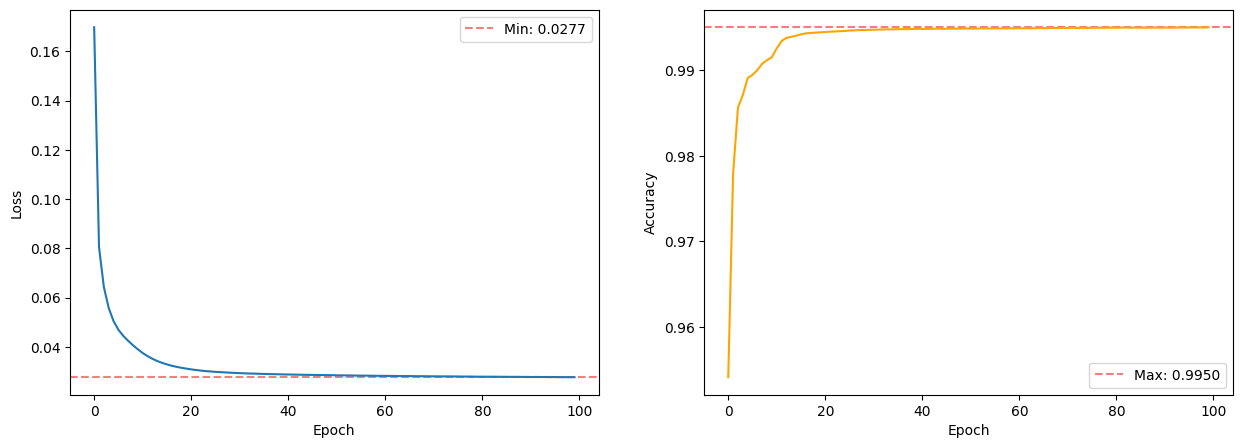


| Metric | Value |
| ------ | ----- |
| Accuracy | 0.9949 |
| Precision | 0.9985 |
| Recall | 0.9583 |
| F1 | 0.9780 |
| Miss Rate | 0.0417 |



In [20]:
# plot training history, loss and accuracy side by side
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
_min = np.min(hist.history['loss'])
ax1.axhline(y=_min, label=f"Min: {_min:.4f}", linestyle='--', color='lightcoral')
ax1.plot(hist.history['loss'])
ax1.set_ylabel('Loss')
ax1.set_xlabel('Epoch')
ax1.legend()
_max = np.max(hist.history['accuracy'])
ax2.axhline(y=_max, label=f"Max: {_max:.4f}", linestyle='--', color='lightcoral')
ax2.plot(hist.history['accuracy'], color='orange')
ax2.set_ylabel('Accuracy')
ax2.set_xlabel('Epoch')
ax2.legend()
plt.show()

# print evaluation metrics in a markdown table

print(f"""
| Metric | Value |
| ------ | ----- |
| Accuracy | {acc:.4f} |
| Precision | {prec:.4f} |
| Recall | {rec:.4f} |
| F1 | {f1:.4f} |
| Miss Rate | {miss:.4f} |
""")


